# Imports

In [1]:
# !pip install tqdm 

import os
import json
import time
import pytz
import numpy as np
import unicodecsv as csv
import pandas as pd
from datetime import datetime
import statsmodels.api as stats_api
import matplotlib.pyplot as plt
from tqdm import tqdm 
from os.path import join
import math
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.neighbors import KNeighborsRegressor

import re

import warnings
warnings.filterwarnings("ignore")

/Users/gringotts/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Loading Dataset

In [2]:
pst_tz = pytz.timezone('US/Pacific')

hashtags = {'gohawks' : 188136,'nfl' : 259024,'sb49' : 826951,'gopatriots' : 26232,'patriots' : 489713,'superbowl' : 1348767 }

df_columns = ['date', 'timestamp', 'retweets','followers','author_id','tweet_id','title','location','impressionCount',
             'favoriteCount','rankingScore','userID','longTweet']

feature_names = ['Number of Tweets', 'Number of Retweets', 'Number of Followers', 'Max Number of Followers', 'Hour of Day',
                  'Impression Count', 'Favourite Count', 'Ranking Score', 'Number of Users tweeting',
'Number of Long Tweets']

bypass = False

In [4]:
#load data

for (hashtag,lcount) in hashtags.items():
    print ("*****", hashtag + ":")
    
    df = pd.DataFrame(index=range(lcount), columns=df_columns)
    users = {}
    
    lno = 0
    
    print('Processing',hashtag)
    
    with open(join('tweet_data', 'tweets_#' + hashtag + '.txt'), 'r') as f:
        
        if(not os.path.isfile('temp/'+hashtag+'.csv') or not bypass):
            with open('temp/'+hashtag+'.csv','wb') as f_csv:
                writer = csv.writer(f_csv)
                writer.writerow(df_columns)
                line = f.readline()

                while(line):
            
                    if(lno%20000 == 0):
                        print(lno)

                    j = json.loads(line)
                    lno += 1

                    date = j['firstpost_date']
                    timestamp = j['citation_date']
                  
                    timestamp = datetime.fromtimestamp(timestamp, pst_tz)
                    date = datetime.fromtimestamp(date, pst_tz)
                    
                    retweets = j['metrics']['citations']['total']        
                    author_id = j['author']['url']
                    followers = j['author']['followers']
                    tweet_id = j['tweet']['id']
                    title = j['title']
                    title = "\"" + title + "\""
                    location = j['tweet']['user']['location']

                    impressionCount = j.get('metrics').get('impressions')
                    favoriteCount = j.get('tweet').get('favorite_count')
                    rankingScore = j.get('metrics').get('ranking_score')
                    userID = j.get('tweet').get('user').get('id')
                    longTweet = len(j.get('title'))>100
                    if len(j.get('title'))>100:
                        longTweet = True
                    else:
                        longTweet = False           
                    
                    writer.writerow([date,timestamp,retweets,followers,author_id,tweet_id,title,location, impressionCount,favoriteCount,rankingScore,userID,longTweet])

                    line = f.readline()
        else:
            
            df = pd.read_csv('temp/'+hashtag+'.csv')

            df['tweetCount'] = [1]*df.shape[0]
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            hourlySeries = df.groupby(pd.TimeGrouper(key='timestamp', freq='60min'))
            tweet_counts = []
            follower_counts = []
            retweet_counts = []
            
            for i,(interval,group) in enumerate(hourlySeries):
                tweet_count = group.tweetCount.sum()
                tweet_counts.append(tweet_count)

                if tweet_count > 0:
                    retweet_counts.append(group.retweets.sum() / tweet_count)
                    follower_counts.append(group.followers.sum() / tweet_count )
                    
                else:
                    retweet_counts.append(0)
                    follower_counts.append(0)

***** gohawks:
Processing gohawks
0
20000
40000
60000
80000
100000
120000
140000
160000
180000
***** nfl:
Processing nfl
0
20000
40000
60000
80000
100000
120000
140000
160000
180000
200000
220000
240000
***** sb49:
Processing sb49
0
20000
40000
60000
80000
100000
120000
140000
160000
180000
200000
220000
240000
260000
280000
300000
320000
340000
360000
380000
400000
420000
440000
460000
480000
500000
520000
540000
560000
580000
600000
620000
640000
660000
680000
700000
720000
740000
760000
780000
800000
820000
***** gopatriots:
Processing gopatriots
0
20000
***** patriots:
Processing patriots
0
20000
40000
60000
80000
100000
120000
140000
160000
180000
200000
220000
240000
260000
280000
300000
320000
340000
360000
380000
400000
420000
440000
460000
480000
***** superbowl:
Processing superbowl
0
20000
40000
60000
80000
100000
120000
140000
160000
180000
200000
220000
240000
260000
280000
300000
320000
340000
360000
380000
400000
420000
440000
460000
480000
500000
520000
540000
560000
58

In [5]:
for (hashtag,lcount) in hashtags.items():
    
    df = pd.read_csv('temp/'+hashtag+'.csv')
    
    df['tweetCount'] = [1]*df.shape[0]
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    hourlySeries = df.groupby(pd.TimeGrouper(key='timestamp', freq='60min'))

    tweet_counts = []
    follower_counts = []
    retweet_counts = []

    for i,(interval,group) in enumerate(hourlySeries):
        tweet_count = group.tweetCount.sum()
        tweet_counts.append(tweet_count)

        if tweet_count > 0:
            retweet_counts.append(group.retweets.sum() / tweet_count)
            follower_counts.append(group.followers.sum() / tweet_count )

        else:
            retweet_counts.append(0)
            follower_counts.append(0)

# Question 1.1:

*****gohawks*****
Average number of tweets per hour:  324.932642487
Average number of followers per user:  2486.52639991
Average number of retweets per tweet:  2.05093001776
*****nfl*****
Average number of tweets per hour:  441.26746167
Average number of followers per user:  4464.54966268
Average number of retweets per tweet:  1.48767458976


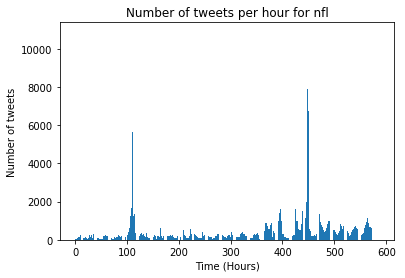

*****sb49*****
Average number of tweets per hour:  1418.44082333
Average number of followers per user:  23375.2180833
Average number of retweets per tweet:  3.33354739078
*****gopatriots*****
Average number of tweets per hour:  45.6208695652
Average number of followers per user:  1554.32960469
Average number of retweets per tweet:  1.36716163269
*****patriots*****
Average number of tweets per hour:  834.264054514
Average number of followers per user:  7202.97452982
Average number of retweets per tweet:  2.45580751081
*****superbowl*****
Average number of tweets per hour:  2297.72913118
Average number of followers per user:  14917.0503276
Average number of retweets per tweet:  2.27858791203


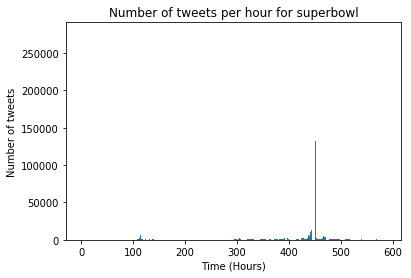

In [37]:
#Question 1.1

for (hashtag,lcount) in  hashtags.items():          
    df = pd.read_csv('temp/'+hashtag+'.csv') 
    
    df['tweetCount'] = [1]*df.shape[0]
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    hourlySeries = df.groupby(pd.TimeGrouper(key='timestamp', freq='60min'))

    tweet_counts = []
    follower_counts = []
    retweet_counts = []

    for i,(interval,group) in enumerate(hourlySeries):
        tweet_count = group.tweetCount.sum()
        tweet_counts.append(tweet_count)

        if tweet_count > 0:
            retweet_counts.append(group.retweets.sum() / tweet_count)
            follower_counts.append(group.followers.sum() / tweet_count )

        else:
            retweet_counts.append(0)
            follower_counts.append(0)
                
    print ("*****"+ hashtag + "*****")
    print ("Average number of tweets per hour: ", np.mean(tweet_counts))
    print ("Average number of followers per user: ", np.mean(follower_counts))
    print ("Average number of retweets per tweet: ", np.mean(retweet_counts))
            
    if hashtag in ['superbowl', "nfl"]:
        
        plt.ylabel('Number of tweets')
        plt.xlabel('Time (Hours)')
        plt.title('Number of tweets per hour for {}'.format(hashtag))
        plt.bar(range(len(tweet_counts)),tweet_counts)
        plt.show()


# Question 1.2: 

In [34]:
for (hashtag,lcount) in hashtags.items():
    
    print ("\n\n******Extracting features from tweets****** for ", hashtag, "\n\n")
    df = pd.read_csv('temp/'+hashtag+'.csv') 


    df['tweetCount'] = [1]*df.shape[0]
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    hourlySeries = df.groupby(pd.TimeGrouper(key='timestamp', freq='60min'))

    tweet_counts = []
    follower_counts = []
    retweet_counts = []

    for i,(interval,group) in enumerate(hourlySeries):
        tweet_count = group.tweetCount.sum()
        tweet_counts.append(tweet_count)

        if tweet_count > 0:
            retweet_counts.append(group.retweets.sum() / tweet_count)
            follower_counts.append(group.followers.sum() / tweet_count )

        else:
            retweet_counts.append(0)
            follower_counts.append(0)
    X = np.zeros((len(hourlySeries),5))
    Y = np.zeros((len(hourlySeries)))

    for i,(interval,group) in enumerate(hourlySeries):
        X[i, 0] = group.tweetCount.sum()
        X[i, 1] = group.retweets.sum()
        X[i, 2] = group.followers.sum()
        X[i, 3] = group.followers.max()
        X[i, 4] = interval.hour


        Y[i] = group.tweetCount.sum()

    X = np.nan_to_num(X[:-1])
    Y = Y[1:]

    
    lr_model = stats_api.OLS(Y, X).fit()
    predicted = lr_model.predict(X)
            
    rmse = math.sqrt(mean_squared_error(Y,predicted))
    print('RMSE:',rmse)
            
    print (lr_model.summary())



******Extracting features from tweets****** for  gohawks 


RMSE: 969.1739711655209
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                     117.2
Date:                Mon, 19 Mar 2018   Prob (F-statistic):           3.05e-85
Time:                        19:25:27   Log-Likelihood:                -4794.7
No. Observations:                 578   AIC:                             9599.
Df Residuals:                     573   BIC:                             9621.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

RMSE: 2523.7470774584417
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     249.0
Date:                Mon, 19 Mar 2018   Prob (F-statistic):          7.04e-142
Time:                        19:25:53   Log-Likelihood:                -5421.9
No. Observations:                 586   AIC:                         1.085e+04
Df Residuals:                     581   BIC:                         1.088e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9189      

# Question 1.3: 

*****gohawks*****
Fitting a new model: # gohawks
RMSE: 888.0585321925902
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     80.02
Date:                Mon, 19 Mar 2018   Prob (F-statistic):          1.22e-101
Time:                        19:34:33   Log-Likelihood:                -4744.2
No. Observations:                 578   AIC:                             9508.
Df Residuals:                     568   BIC:                             9552.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

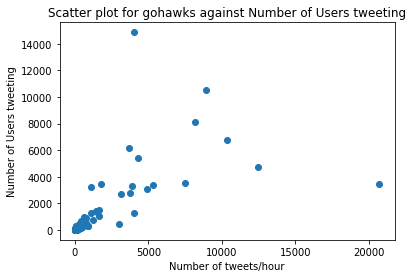

Number of Tweets


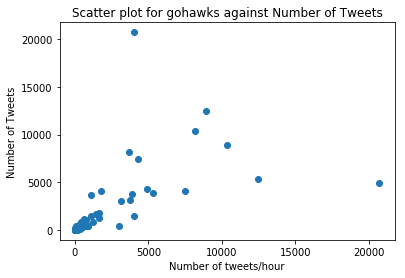

Number of Followers


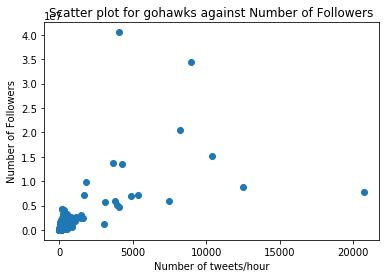

*****nfl*****
Fitting a new model: # nfl
RMSE: 541.9040560922512
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     132.9
Date:                Mon, 19 Mar 2018   Prob (F-statistic):          1.74e-142
Time:                        19:34:39   Log-Likelihood:                -4520.4
No. Observations:                 586   AIC:                             9061.
Df Residuals:                     576   BIC:                             9105.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

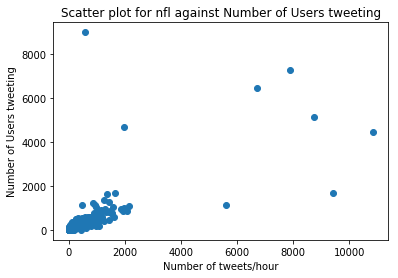

Number of Tweets


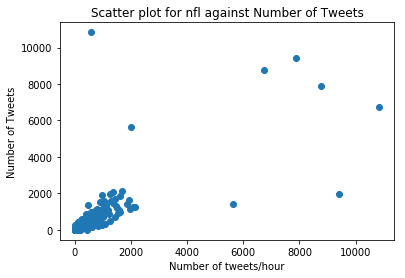

Hour of Day


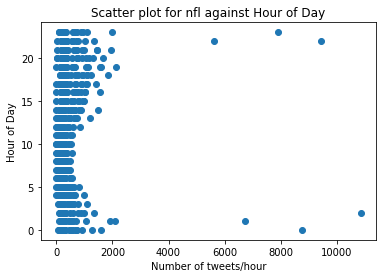

*****sb49*****
Fitting a new model: # sb49
RMSE: 4384.710850523516
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     253.5
Date:                Mon, 19 Mar 2018   Prob (F-statistic):          8.00e-203
Time:                        19:34:54   Log-Likelihood:                -5706.4
No. Observations:                 582   AIC:                         1.143e+04
Df Residuals:                     572   BIC:                         1.148e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

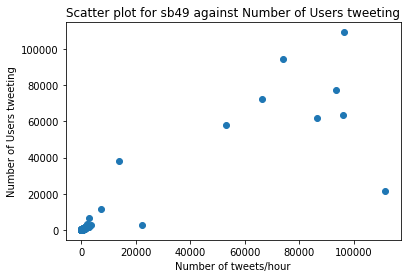

Number of Followers


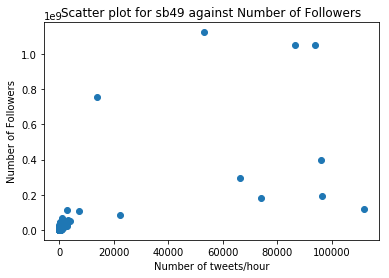

Number of Tweets


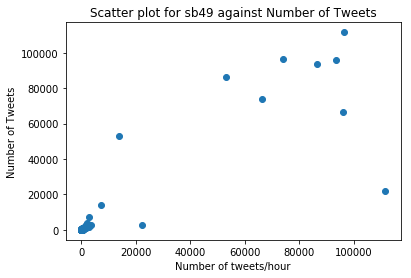

*****gopatriots*****
Fitting a new model: # gopatriots
RMSE: 142.9312346874742
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     206.1
Date:                Mon, 19 Mar 2018   Prob (F-statistic):          4.78e-181
Time:                        19:34:55   Log-Likelihood:                -3662.9
No. Observations:                 574   AIC:                             7346.
Df Residuals:                     564   BIC:                             7389.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

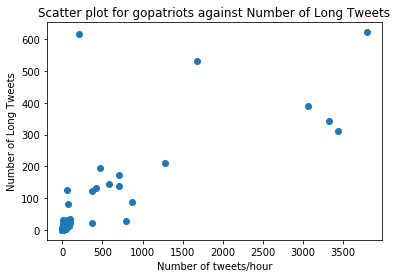

Number of Users tweeting


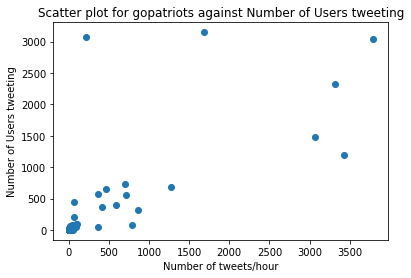

Number of Tweets


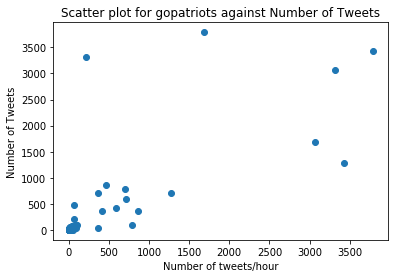

*****patriots*****
Fitting a new model: # patriots
RMSE: 2275.4326174059424
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     165.1
Date:                Mon, 19 Mar 2018   Prob (F-statistic):          6.47e-162
Time:                        19:35:04   Log-Likelihood:                -5361.2
No. Observations:                 586   AIC:                         1.074e+04
Df Residuals:                     576   BIC:                         1.079e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

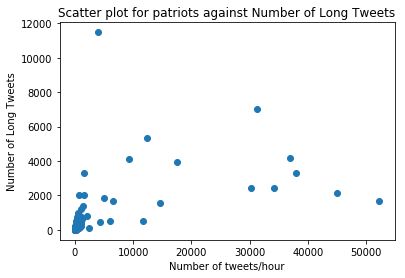

Number of Followers


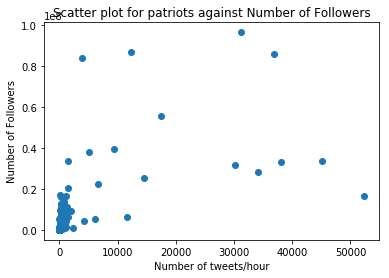

Number of Users tweeting


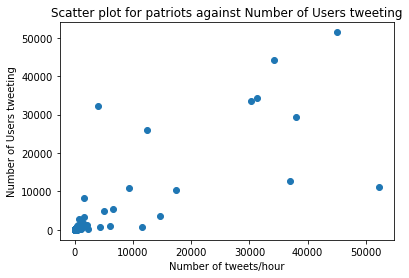

*****superbowl*****
Fitting a new model: # superbowl
RMSE: 7261.918282090959
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     301.9
Date:                Mon, 19 Mar 2018   Prob (F-statistic):          1.37e-221
Time:                        19:35:26   Log-Likelihood:                -6041.3
No. Observations:                 586   AIC:                         1.210e+04
Df Residuals:                     576   BIC:                         1.215e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

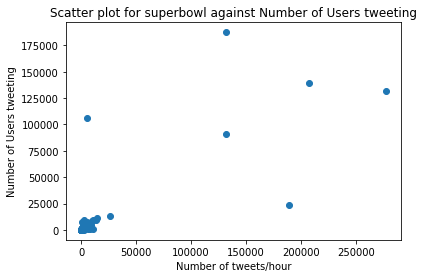

Number of Retweets


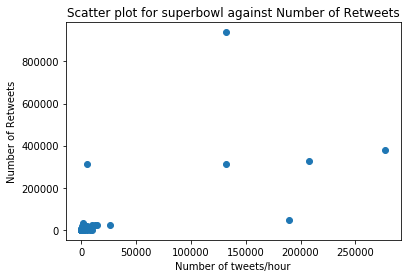

Number of Tweets


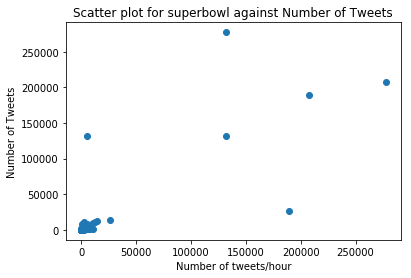

In [36]:
# Question 1.3

for (hashtag,lcount) in hashtags.items():
    
    print('*****'+ hashtag + '*****')
    
    df = pd.DataFrame(index=range(lcount), columns=df_columns)
    df = pd.read_csv('temp/'+hashtag+'.csv')
        
    print ('Fitting a new model: #', hashtag)
    
    df['tweetCount'] = [1]*df.shape[0]
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    hourlySeries = df.groupby(pd.TimeGrouper(key='timestamp', freq='60min'))

    tweet_counts = []
    follower_counts = []
    retweet_counts = []

    for i,(interval,group) in enumerate(hourlySeries):
        tweet_count = group.tweetCount.sum()
        tweet_counts.append(tweet_count)

        if tweet_count > 0:
            retweet_counts.append(group.retweets.sum() / tweet_count)
            follower_counts.append(group.followers.sum() / tweet_count )

        else:
            retweet_counts.append(0)
            follower_counts.append(0)
            
    X = np.zeros((len(hourlySeries), 10))
    Y = np.zeros((len(hourlySeries)))

    for i,(interval,group) in enumerate(hourlySeries):           
        X[i, 0] = group.tweetCount.sum()
        X[i, 1] = group.retweets.sum()
        X[i, 2] = group.followers.sum()
        X[i, 3] = group.followers.max()
        X[i, 4] = interval.hour

        # New features

        X[i ,5] = group.impressionCount.sum()/X[i,0]
        X[i, 6] = group.favoriteCount.sum()/X[i,0]
        X[i,7] = group.rankingScore.sum()/X[i,0]
        X[i,8] = group.userID.nunique()
        X[i,9] = group.longTweet.sum()

        Y[i] = group.tweetCount.sum()


    X = np.nan_to_num(X[:-1])
    Y = Y[1:]


    stats_api.add_constant(X)
    lr_model = stats_api.OLS(Y, X).fit()
    predicted = lr_model.predict(X)

    rmse = sqrt(mean_squared_error(Y,predicted))
    print('RMSE:',rmse)

    print (lr_model.summary())

    best_features = lr_model.pvalues.argsort()[:3]
    sel_feats = [feature_names[i] for i in best_features]
    print ("\n\nBest features selected are: ", sel_feats, "\n\n")

    for i in best_features:
        print (feature_names[i])
        plt.title("Scatter plot for {0} against {1}".format(hashtag, feature_names[i]))
        plt.xlabel("Number of tweets/hour")
        plt.ylabel(feature_names[i])
        plt.scatter(Y, X[:, i])
#         f, ax = plt.subplots()
#         ax.scatter(Y, X[:, i])
#         ax.plot(ax.get_xlim(), ax.get_ylim(), 'r-')
        plt.plot()
        plt.show()

# Question 1.4 (i): 

In [197]:
# Question 1.4

def cross_validate_per_timeslot(df,avg_rmse,avg_mae):
    #df = df.set_index('date')
    df['date'] = pd.to_datetime(df['date'])
    hourlySeries = df.groupby(pd.Grouper(key='date',freq='60Min'))

    X = np.zeros((len(hourlySeries), 10))
    Y = np.zeros((len(hourlySeries), 1))

    
    # Extract features for each hourly interval
    for i,(interval,group) in enumerate(hourlySeries):
        X[i, 0] = group.tweetCount.sum()
        X[i, 1] = group.retweets.sum()
        X[i, 2] = group.followers.sum()
        X[i, 3] = group.followers.max()
        X[i, 4] = interval.hour
        X[i, 5] = group.impressionCount.sum()/X[i,0]
        X[i, 6] = group.favoriteCount.sum()/X[i,0]
        X[i,7] = group.rankingScore.sum()/X[i,0]
        X[i,8] = group.userID.nunique()
        X[i,9] = group.longTweet.sum()
        
        Y[i, 0] = group.tweetCount.sum()

    X = np.nan_to_num(X[:-1])
    Y = Y[1:]

    k=KFold(n_splits=10)
    mae = []
    rmse = []
    for train_index, test_index in k.split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        result = stats_api.OLS(Y_train, X_train).fit()
        prediction = result.predict(X_test)

        mae.append(mean_absolute_error(Y_test, prediction))
        rmse.append(sqrt(mean_squared_error(Y_test,prediction)))
        
    print ("Mean absolute error was", np.mean(mae))
    print ("Root Mean Squared error was", np.mean(rmse))
    avg_rmse.append(np.mean(rmse))
    avg_mae.append(np.mean(mae))

for (hashtag,lcount) in hashtags.items():
    df = pd.DataFrame(index=range(lcount), columns=df_columns)
    df = pd.read_csv('temp/'+hashtag+'.csv')
    df['tweetCount'] = [1]*df.shape[0]
    
    start_time = datetime(2015,2,1,8,0,0)
    end_time = datetime(2015,2,1,20,0,0)
    avg_rmse = []
    avg_mae = []
    
    print("*********",hashtag,"*********")
    print ("Cross Validation over all the values: ")
    cross_validate_per_timeslot(df,avg_rmse,avg_mae)
    print("Cross Validation over the first time slot")
    df1 = df[df['date'] < start_time]
    cross_validate_per_timeslot(df1,avg_rmse,avg_mae)
    print("Cross Validation over the second time slot")
    df2 = df[(df.date > start_time) & (df.date < end_time)]
    cross_validate_per_timeslot(df2,avg_rmse,avg_mae)
    print("Cross Validation over the third time slot")
    df2 = df[df.date > end_time]
    cross_validate_per_timeslot(df2,avg_rmse,avg_mae)
    
    print("\n\n*******Minimum Average MAE:  ",min(avg_mae),"at position",avg_mae.index(min(avg_mae)))

********* gohawks *********
Cross Validation over all the values: 
Mean absolute error was 158.77963488
Root Mean Squared error was 432.364382008
Cross Validation over the first time slot
Mean absolute error was 152.110019512
Root Mean Squared error was 406.43115116
Cross Validation over the second time slot
Mean absolute error was 9274.36192195
Root Mean Squared error was 9280.34284477
Cross Validation over the third time slot
Mean absolute error was 804.642903079
Root Mean Squared error was 1987.78006521


*******Minimum Average MAE:   152.110019512 at position 1
********* nfl *********
Cross Validation over all the values: 
Mean absolute error was 133.158231072
Root Mean Squared error was 286.098965059
Cross Validation over the first time slot
Mean absolute error was 71.229758168
Root Mean Squared error was 138.147323714
Cross Validation over the second time slot
Mean absolute error was 2540.96485793
Root Mean Squared error was 2650.69394566
Cross Validation over the third time slot

In [204]:
def cross_validate_per_timeslot(df,avg_rmse,avg_mae):
    #df = df.set_index('date')
    df['date'] = pd.to_datetime(df['date'])
    hourlySeries = df.groupby(pd.Grouper(key='date',freq='60Min'))

    X = np.zeros((len(hourlySeries), 10))
    Y = np.zeros((len(hourlySeries), 1))

    # Extract features for each hourly interval
    for i,(interval,group) in enumerate(hourlySeries):        
        X[i, 0] = group.tweetCount.sum()
        X[i, 1] = group.retweets.sum()
        X[i, 2] = group.followers.sum()
        X[i, 3] = group.followers.max()
        X[i, 4] = interval.hour
        X[i, 5] = group.impressionCount.sum()/X[i,0]
        X[i, 6] = group.favoriteCount.sum()/X[i,0]
        X[i,7] = group.rankingScore.sum()/X[i,0]
        X[i,8] = group.userID.nunique()
        X[i,9] = group.longTweet.sum()
        
        Y[i, 0] = group.tweetCount.sum()


    # Shift X and Y forward by one to reflect next hours predictions
    X = np.nan_to_num(X[:-1])
    Y = Y[1:]

    k=KFold(n_splits=10)
    mae = []
    rmse = []
    knnreg = KNeighborsRegressor()
    for train_index, test_index in k.split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        result = knnreg.fit(X_train, Y_train)
        prediction = result.predict(X_test)

        mae.append(mean_absolute_error(Y_test, prediction))
        rmse.append(sqrt(mean_squared_error(Y_test,prediction)))
        
    print ("Mean absolute error was", np.mean(mae))
    print ("Root Mean Squared error was", np.mean(rmse))
    avg_rmse.append(np.mean(rmse))
    avg_mae.append(np.mean(mae))
    #visited=1

for (hashtag,lcount) in hashtags.items():
    df = pd.DataFrame(index=range(lcount), columns=df_columns)
    df = pd.read_csv('temp/'+hashtag+'.csv')
    df['tweetCount'] = [1]*df.shape[0]
    
    start_time = datetime(2015,2,1,8,0,0)
    end_time = datetime(2015,2,1,20,0,0)
    avg_rmse = []
    avg_mae = []
    
    print("*********",hashtag,"*********")
    print ("Cross Validation over all the values")
    cross_validate_per_timeslot(df,avg_rmse,avg_mae)
    print("Cross Validation over the first time slot")
    df1 = df[df['date'] < start_time]
    cross_validate_per_timeslot(df1,avg_rmse,avg_mae)
    print("Cross Validation over the second time slot")
    df2 = df[(df.date > start_time) & (df.date < end_time)]
    cross_validate_per_timeslot(df2,avg_rmse,avg_mae)
    print("Cross Validation over the third time slot")
    df2 = df[df.date > end_time]
    cross_validate_per_timeslot(df2,avg_rmse,avg_mae)
    print("\n\n******Minimum Average MAE:  ",min(avg_mae),"at position",avg_mae.index(min(avg_mae)))

********* gohawks *********
Cross Validation over all the values
Mean absolute error was 110.525356617
Root Mean Squared error was 329.659475719
Cross Validation over the first time slot
Mean absolute error was 99.8855627388
Root Mean Squared error was 311.895489853
Cross Validation over the second time slot
Mean absolute error was 648.09
Root Mean Squared error was 648.375772142
Cross Validation over the third time slot
Mean absolute error was 401.334285714
Root Mean Squared error was 594.221610402


******Minimum Average MAE:   99.8855627388 at position 1
********* nfl *********
Cross Validation over all the values
Mean absolute error was 152.100374007
Root Mean Squared error was 360.511712604
Cross Validation over the first time slot
Mean absolute error was 87.7858008658
Root Mean Squared error was 171.835789636
Cross Validation over the second time slot
Mean absolute error was 358.67
Root Mean Squared error was 358.857200002
Cross Validation over the third time slot
Mean absolute e

In [84]:
from sklearn.ensemble import RandomForestRegressor
def cross_validate_per_timeslot(df,avg_rmse,avg_mae):
    #df = df.set_index('date')
    df['date'] = pd.to_datetime(df['date'])
    hourlySeries = df.groupby(pd.Grouper(key='date',freq='60Min'))

    X = np.zeros((len(hourlySeries), 10))
    Y = np.zeros((len(hourlySeries), 1))

    # Extract features for each hourly interval
    for i,(interval,group) in enumerate(hourlySeries):
        X[i, 0] = group.tweetCount.sum()
        X[i, 1] = group.retweets.sum()
        X[i, 2] = group.followers.sum()
        X[i, 3] = group.followers.max()
        X[i, 4] = interval.hour
        X[i, 5] = group.impressionCount.sum()/X[i,0]
        X[i, 6] = group.favoriteCount.sum()/X[i,0]
        X[i,7] = group.rankingScore.sum()/X[i,0]
        X[i,8] = group.userID.nunique()
        X[i,9] = group.longTweet.sum()
        
        Y[i, 0] = group.tweetCount.sum()

    X = np.nan_to_num(X[:-1])
    Y = Y[1:]

    k=KFold(n_splits=10)
    mae = []
    rmse = []
    regr = RandomForestRegressor(n_estimators=20, max_depth=4,max_features=5, oob_score=True)
    for train_index, test_index in k.split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        result = regr.fit(X_train, Y_train)
        prediction = result.predict(X_test)

        mae.append(mean_absolute_error(Y_test, prediction))
        rmse.append(sqrt(mean_squared_error(Y_test,prediction)))
        
    print ("Mean absolute error was", np.mean(mae))
    print ("Root Mean Squared error was", np.mean(rmse))
    avg_rmse.append(np.mean(rmse))
    avg_mae.append(np.mean(mae))
    #visited=1
    
print("dafuq")
for (hashtag,lcount) in hashtags.items():
    df = pd.DataFrame(index=range(lcount), columns=df_columns)
    df = pd.read_csv('temp/'+hashtag+'.csv')
    df['tweetCount'] = [1]*df.shape[0]
    
    start_time = datetime(2015,2,1,8,0,0)
    end_time = datetime(2015,2,1,20,0,0)
    avg_rmse = []
    avg_mae = []
    print("*********",hashtag,"*********")
    print ("Cross Validation over all the values")
    cross_validate_per_timeslot(df,avg_rmse,avg_mae)
    print("Cross Validation over the first time slot")
    df1 = df[df['date'] < start_time]
    cross_validate_per_timeslot(df1,avg_rmse,avg_mae)
    print("Cross Validation over the second time slot")
    df2 = df[(df.date > start_time) & (df.date < end_time)]
    cross_validate_per_timeslot(df2,avg_rmse,avg_mae)
    print("Cross Validation over the third time slot")
    df2 = df[df.date > end_time]
    cross_validate_per_timeslot(df2,avg_rmse,avg_mae)
    print("\n\nMinimum Average MAE: ",min(avg_mae)," at position ",avg_mae.index(min(avg_mae)))

dafuq
********* gohawks *********
Cross Validation over all the values
Mean absolute error was 97.6805234344
Root Mean Squared error was 295.862196319
Cross Validation over the first time slot
Mean absolute error was 89.7599197919
Root Mean Squared error was 291.09584753
Cross Validation over the second time slot
Mean absolute error was 496.07625
Root Mean Squared error was 496.668778126
Cross Validation over the third time slot
Mean absolute error was 402.269936219
Root Mean Squared error was 615.218150932


Minimum Average MAE:  89.7599197919  at position  1
********* nfl *********
Cross Validation over all the values
Mean absolute error was 137.705378558
Root Mean Squared error was 359.938256436
Cross Validation over the first time slot
Mean absolute error was 62.7680536091
Root Mean Squared error was 126.124280328
Cross Validation over the second time slot
Mean absolute error was 255.823666667
Root Mean Squared error was 258.185525493
Cross Validation over the third time slot
Mean 

# Question 1.4 (ii):

In [124]:
def cross_validate_per_timeslot(df,avg_rmse,avg_mae):
    df['date'] = pd.to_datetime(df['date'])
    hourlySeries = df.groupby(pd.Grouper(key='date',freq='60Min'))

    X = np.zeros((len(hourlySeries), 10))
    Y = np.zeros((len(hourlySeries), 1))

    for i,(interval,group) in enumerate(hourlySeries):
        
        X[i, 0] = group.tweetCount.sum()
        X[i, 1] = group.retweets.sum()
        X[i, 2] = group.followers.sum()
        X[i, 3] = group.followers.max()
        X[i, 4] = interval.hour
        X[i, 5] = group.impressionCount.sum()/X[i,0]
        X[i, 6] = group.favoriteCount.sum()/X[i,0]
        X[i,7] = group.rankingScore.sum()/X[i,0]
        X[i,8] = group.userID.nunique()
        X[i,9] = group.longTweet.sum()
        
        Y[i, 0] = group.tweetCount.sum()

    X = np.nan_to_num(X[:-1])
    Y = Y[1:]
    regr = RandomForestRegressor(n_estimators=20, max_depth=4,max_features=5, oob_score=True)
    k=KFold(n_splits=10)
    mae = []
    rmse = []
    for train_index, test_index in k.split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        result = regr.fit(X_train, Y_train)
        prediction = result.predict(X_test)

        mae.append(mean_absolute_error(Y_test, prediction))
        rmse.append(sqrt(mean_squared_error(Y_test,prediction)))
        
    print ("Mean absolute error was", np.mean(mae))
    print ("Root Mean Squared error was", np.mean(rmse))
    avg_rmse.append(np.mean(rmse))
    avg_mae.append(np.mean(mae))

df3 = pd.read_csv('temp/gohawks.csv')
df4 = pd.read_csv('temp/nfl.csv')
df5= pd.read_csv('temp/sb49.csv')
df6= pd.read_csv('temp/gopatriots.csv')
df7= pd.read_csv('temp/patriots.csv')
df8= pd.read_csv('temp/superbowl.csv')
df9=pd.concat([df3,df4,df5,df6,df7,df8])
df9['tweetCount'] = [1]*df9.shape[0]

start_time = datetime(2015,2,1,8,0,0)
end_time = datetime(2015,2,1,20,0,0)
avg_rmse = []
avg_mae = []
print ("cross validation over all values")
cross_validate_per_timeslot(df9,avg_rmse,avg_mae)
print("cross validation over first time slot")
df10 = df9[df9['date'] < start_time]
cross_validate_per_timeslot(df10,avg_rmse,avg_mae)
print("cross validation over second time slot")
df11 = df9[(df9.date > start_time) & (df9.date < end_time)]
cross_validate_per_timeslot(df11,avg_rmse,avg_mae)
print("cross validation over third time slot")
df12 = df9[df9.date > end_time]
cross_validate_per_timeslot(df12,avg_rmse,avg_mae)

cross validation over all values
Mean absolute error was 2668.51380121
Root Mean Squared error was 9015.42504924
cross validation over first time slot
Mean absolute error was 349.188986012
Root Mean Squared error was 861.819942694
cross validation over second time slot
Mean absolute error was 25069.0391667
Root Mean Squared error was 25138.1972434
cross validation over third time slot
Mean absolute error was 13023.4550406
Root Mean Squared error was 20156.9864592


# Question 1.5: 

In [92]:
def cross_validate_per_timeslot(df,avg_rmse,avg_mae):
    df['date'] = pd.to_datetime(df['date'])
    hourlySeries = df.groupby(pd.Grouper(key='date',freq='60Min'))

    X = np.zeros((len(hourlySeries), 10))
    Y = np.zeros((len(hourlySeries), 1))
    
    for i,(interval,group) in enumerate(hourlySeries):
        
        X[i, 0] = group.tweetCount.sum()
        X[i, 1] = group.retweets.sum()
        X[i, 2] = group.followers.sum()
        X[i, 3] = group.followers.max()
        X[i, 4] = interval.hour
        X[i, 5] = group.impressionCount.sum()/X[i,0]
        X[i, 6] = group.favoriteCount.sum()/X[i,0]
        X[i,7] = group.rankingScore.sum()/X[i,0]
        X[i,8] = group.userID.nunique()
        X[i,9] = group.longTweet.sum()
        
        Y[i, 0] = group.tweetCount.sum()
        
    X_50 = []
    Y_new = []
    
    for i in range(0, len(X)-5):
        x_temp = X[i] + X[i+1] + X[i+2] + X[i+3] + X[i+4]
        y_temp = Y[i+5]

        X_50.append(x_temp)
        Y_new.append(y_temp)
        
    X_50 = np.nan_to_num(X_50)

    regr = RandomForestRegressor(n_estimators=20, max_depth=4,max_features=5, oob_score=True)
    result = regr.fit(X_50, Y_new)
    return result

def result_fn(df,avg_rmse,avg_mae):
    df['date'] = pd.to_datetime(df['date'])
    hourlySeries = df.groupby(pd.Grouper(key='date',freq='60Min'))

    X = np.zeros((len(hourlySeries), 10))
    Y = np.zeros((len(hourlySeries), 1))
    for i,(interval,group) in enumerate(hourlySeries):
        
        
        X[i, 0] = group.tweetCount.sum()
        X[i, 1] = group.retweets.sum()
        X[i, 2] = group.followers.sum()
        X[i, 3] = group.followers.max()
        X[i, 4] = interval.hour
        X[i, 5] = group.impressionCount.sum()/X[i,0]
        X[i, 6] = group.favoriteCount.sum()/X[i,0]
        X[i,7] = group.rankingScore.sum()/X[i,0]
        X[i,8] = group.userID.nunique()
        X[i,9] = group.longTweet.sum()
        
        Y[i, 0] = group.tweetCount.sum()
    
    X_50 = []
    Y_new = []
    
    for i in range(0, len(X)-5): 
        x_temp = X[i] + X[i+1] + X[i+2] + X[i+3] + X[i+4]
        y_temp = Y[i+5]

        X_50.append(x_temp)
        Y_new.append(y_temp)
        
    X_50 = np.nan_to_num(X_50)

    return X_50,Y_new

df9['tweetCount'] = [1]*df9.shape[0]
avg_rmse = []
avg_mae = []
start_time = datetime(2015,2,1,8,0,0)
end_time = datetime(2015,2,1,20,0,0)

print ("cross validation over all values")

cross_validate_per_timeslot(df9,avg_rmse,avg_mae)
print("cross validation over first time slot")
df10 = df9[df9['date'] < start_time]
regr1=cross_validate_per_timeslot(df10,avg_rmse,avg_mae)

print("cross validation over second time slot")
df11 = df9[(df9.date > start_time) & (df9.date < end_time)]
regr2 =cross_validate_per_timeslot(df11,avg_rmse,avg_mae)

print("cross validation over third time slot")
df12 = df9[df9.date > end_time]
regr3=cross_validate_per_timeslot(df12,avg_rmse,avg_mae)

test_data = {
    "sample10_period3.txt" : 365,
    "sample1_period1.txt" : 730,
    "sample2_period2.txt" : 212273,
    "sample3_period3.txt" : 3638,
    "sample4_period1.txt" : 1646,
    "sample5_period1.txt" : 2059,
    "sample6_period2.txt" : 205554,
    "sample7_period3.txt" : 528,
    "sample9_period2.txt" : 11311
}


for (hashtag,lcount) in test_data.items():
    print('********************', hashtag)
    df13 = pd.DataFrame(index=range(lcount), columns=df_columns)
    df13 = pd.read_csv('temp_test/'+hashtag+'.csv')
    rg = re.search('.*?(\\d+).*?(\\d+)', hashtag)
    
    period = rg.group(2)
    
    df13['tweetCount'] = [1]*df13.shape[0]
    X,Y=result_fn(df13, avg_rmse, avg_mae)
    
    prediction = None
    
    if period=='1':
        prediction = regr1.predict(X)
    if period=='2':
        prediction = regr2.predict(X)
    if period=='3':
        prediction = regr3.predict(X)

    mae=mean_absolute_error(Y, prediction)
    rmse=sqrt(mean_squared_error(Y,prediction))
    print('\nPredictions for the 5 hour window are: ', prediction)
    print ("Mean absolute error was", np.mean(mae))
    print ("Root Mean Squared error was", np.mean(rmse))

cross validation over all values
cross validation over first time slot
cross validation over second time slot
cross validation over third time slot
******************** sample10_period3.txt

Predictions for the 5 hour window are:  [ 59088.21910277]
Mean absolute error was 59027.2191028
Root Mean Squared error was 59027.2191028
******************** sample1_period1.txt

Predictions for the 5 hour window are:  [ 451.50716638]
Mean absolute error was 273.50716638
Root Mean Squared error was 273.50716638
******************** sample2_period2.txt

Predictions for the 5 hour window are:  [ 121629.1]
Mean absolute error was 38706.1
Root Mean Squared error was 38706.1
******************** sample3_period3.txt

Predictions for the 5 hour window are:  [ 1448.06160057]
Mean absolute error was 925.061600569
Root Mean Squared error was 925.061600569
******************** sample4_period1.txt

Predictions for the 5 hour window are:  [ 666.882538]
Mean absolute error was 465.882538001
Root Mean Squared er

In [90]:
def cross_validate_per_timeslot(df,avg_rmse,avg_mae):
    df['date'] = pd.to_datetime(df['date'])
    hourlySeries = df.groupby(pd.Grouper(key='date',freq='60Min'))

    X = np.zeros((len(hourlySeries), 10))
    Y = np.zeros((len(hourlySeries), 1))
    
    for i,(interval,group) in enumerate(hourlySeries):
        
        X[i, 0] = group.tweetCount.sum()
        X[i, 1] = group.retweets.sum()
        X[i, 2] = group.followers.sum()
        X[i, 3] = group.followers.max()
        X[i, 4] = interval.hour
        X[i, 5] = group.impressionCount.sum()/X[i,0]
        X[i, 6] = group.favoriteCount.sum()/X[i,0]
        X[i,7] = group.rankingScore.sum()/X[i,0]
        X[i,8] = group.userID.nunique()
        X[i,9] = group.longTweet.sum()
        
        Y[i, 0] = group.tweetCount.sum()
        
    X_50 = []
    Y_new = []
    
    for i in range(0, len(X)-4):
        x_temp = X[i] + X[i+1] + X[i+2] + X[i+3]  # + X[i+3]
        y_temp = Y[i+4]

        X_50.append(x_temp)
        Y_new.append(y_temp)
        
    X_50 = np.nan_to_num(X_50)
    
    regr = RandomForestRegressor(n_estimators=20, max_depth=4,max_features=5, oob_score=True)
    result = regr.fit(X_50, Y_new)
    return result

def result_fn(df,avg_rmse,avg_mae):
    df['date'] = pd.to_datetime(df['date'])
    hourlySeries = df.groupby(pd.Grouper(key='date',freq='60Min'))

    X = np.zeros((len(hourlySeries), 10))
    Y = np.zeros((len(hourlySeries), 1))
    for i,(interval,group) in enumerate(hourlySeries):
        
        
        X[i, 0] = group.tweetCount.sum()
        X[i, 1] = group.retweets.sum()
        X[i, 2] = group.followers.sum()
        X[i, 3] = group.followers.max()
        X[i, 4] = interval.hour
        X[i, 5] = group.impressionCount.sum()/X[i,0]
        X[i, 6] = group.favoriteCount.sum()/X[i,0]
        X[i,7] = group.rankingScore.sum()/X[i,0]
        X[i,8] = group.userID.nunique()
        X[i,9] = group.longTweet.sum()
        
        Y[i, 0] = group.tweetCount.sum()
    
    X_50 = []
    Y_new = []
    
    for i in range(0, len(X)-4): 
        x_temp = X[i] + X[i+1] + X[i+2] + X[i+3] # + X[i+3]
        y_temp = Y[i+4]

        X_50.append(x_temp)
        Y_new.append(y_temp)
        
    X_50 = np.nan_to_num(X_50)
    
    return X_50,Y_new

df9['tweetCount'] = [1]*df9.shape[0]
avg_rmse = []
avg_mae = []
start_time = datetime(2015,2,1,8,0,0)
end_time = datetime(2015,2,1,20,0,0)

print ("cross validation over all values")

cross_validate_per_timeslot(df9,avg_rmse,avg_mae)
print("cross validation over first time slot")
df10 = df9[df9['date'] < start_time]
regr1=cross_validate_per_timeslot(df10,avg_rmse,avg_mae)

print("cross validation over second time slot")
df11 = df9[(df9.date > start_time) & (df9.date < end_time)]
regr2 =cross_validate_per_timeslot(df11,avg_rmse,avg_mae)

print("cross validation over third time slot")
df12 = df9[df9.date > end_time]
regr3=cross_validate_per_timeslot(df12,avg_rmse,avg_mae)

test_data = {
 "sample8_period1.txt" : 229,
}


for (hashtag,lcount) in test_data.items():
    print('********************', hashtag)
    df13 = pd.DataFrame(index=range(lcount), columns=df_columns)
    df13 = pd.read_csv('temp_test/'+hashtag+'.csv')
    rg = re.search('.*?(\\d+).*?(\\d+)', hashtag)
    
    period = rg.group(2)
    
    df13['tweetCount'] = [1]*df13.shape[0]
    X,Y=result_fn(df13, avg_rmse, avg_mae)
    
    prediction = None
    
    if period=='1':
        prediction = regr1.predict(X)
    if period=='2':
        prediction = regr2.predict(X)
    if period=='3':
        prediction = regr3.predict(X)

    mae=mean_absolute_error(Y, prediction)
    rmse=sqrt(mean_squared_error(Y,prediction))
    print('\nPredictions for the 5 hour window are: ', prediction)
    print ("Mean absolute error was", np.mean(mae))
    print ("Root Mean Squared error was", np.mean(rmse))

cross validation over all values
cross validation over first time slot
cross validation over second time slot
cross validation over third time slot
******************** sample8_period1.txt

Predictions for the 5 hour window are:  [ 11.48449541]
Mean absolute error was 0.484495411071
Root Mean Squared error was 0.484495411071


# Question 3: 

In [9]:
# Question 3

!pip install textblob
from textblob import TextBlob
import re

def clean_tweet(tweet):
    '''
    Utility function to clean the text in a tweet by removing 
    links and special characters using regex.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def analyze_sentiment(tweet):
    '''
    Utility function to classify the polarity of a tweet
    using textblob.
    '''
    analysis = TextBlob(clean_tweet(tweet))
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1

In [38]:
# df1 = pd.read_csv('temp/gohawks.csv')
# df2 = pd.read_csv('temp/nfl.csv')
# df3= pd.read_csv('temp/sb49.csv')
# df4= pd.read_csv('temp/gopatriots.csv')
# df5= pd.read_csv('temp/patriots.csv')
# df6= pd.read_csv('temp/superbowl.csv')
# df=pd.concat([df1,df2,df3,df4,df5,df6])
# df['tweetCount'] = [1]*df.shape[0]

In [150]:
df['SA'] = np.array([ analyze_sentiment(tweet) for tweet in df['title'] ])

In [151]:
df.head(10)

,date,timestamp,retweets,followers,author_id,tweet_id,title,location,impressionCount,favoriteCount,rankingScore,userID,longTweet,tweetCount,SA
0,2014-12-28 14:14:35-08:00,2015-01-17 10:19:38-08:00,5,1752.0,http://twitter.com/rejinseattle,549327579782840320,"""I &lt;3 our defense! #GoHawks http://t.co/U1p...",Ontario,1754,1,4.743703,749230320,False,1,0
1,2014-12-29 06:40:08-08:00,2015-01-14 10:18:56-08:00,2,258.0,http://twitter.com/emq4444,549575600210718721,"""twelfth dogs are ready! #gohawks #dogslife ht...","Redmond, WA",162,0,3.646109,1433777845,False,1,1
2,2014-12-29 07:27:13-08:00,2015-01-15 16:23:55-08:00,7,199.0,http://twitter.com/theuntrainedeye,549587448133873667,"""I'm so excited the road to #SuperBowlXLIX wil...",#Seahawks #Mariners,183,0,4.134341,2374402878,False,1,1
3,2014-12-29 11:27:20-08:00,2015-01-16 20:21:59-08:00,5,22.0,http://twitter.com/beccadelgado67,549647876406534144,"""""Oh no big deal, just NFC West Champs and the...",Seattle,5,0,3.500887,26556905,False,1,0
4,2014-12-29 12:10:38-08:00,2015-01-16 20:21:37-08:00,2,22.0,http://twitter.com/beccadelgado67,549658771749101568,"""At http://t.co/Vd0RWOeAed -- #Seahawks #12thM...",NaN,5,0,3.229207,2419495681,False,1,0
5,2014-12-29 16:39:54-08:00,2015-01-16 20:20:58-08:00,2,22.0,http://twitter.com/beccadelgado67,549726538183507968,"""At http://t.co/Vd0RWOeAed -- Look what we fou...",NaN,5,1,3.179586,2419495681,False,1,-1
6,2014-12-30 10:03:35-08:00,2015-01-16 20:18:56-08:00,2,22.0,http://twitter.com/beccadelgado67,549989186950803456,"""Good luck at Michigan, Jim Harbaugh. #GoHawks...","Buffalo, Wyoming",5,1,3.759005,266124599,False,1,1
7,2014-12-30 16:23:47-08:00,2015-01-16 20:17:48-08:00,3,22.0,http://twitter.com/beccadelgado67,550084869531779073,"""Marathon 12 Barrow @MarathonTires 12 Contract...",NaN,5,0,4.247356,783479653,False,1,0
8,2014-12-30 16:43:03-08:00,2015-01-16 20:17:27-08:00,2,22.0,http://twitter.com/beccadelgado67,550089719485177857,"""Hi my name is Lori and I'm a @Seahawks addict...","Seattle, WA",5,1,4.304159,69445229,False,1,0
9,2014-12-31 08:20:51-08:00,2015-01-16 20:16:16-08:00,2,22.0,http://twitter.com/beccadelgado67,550325724117471232,"""@FiveThirtyEight #GoHawks. Keep your eyes on ...","McChord AFB, WA",5,1,3.718140,570307870,False,1,0


In [11]:
def sentiment_stats(df):    
    pos_tweets = [ tweet for index, tweet in enumerate(df['title']) if df['SA'][index] > 0]
    neu_tweets = [ tweet for index, tweet in enumerate(df['title']) if df['SA'][index] == 0]
    neg_tweets = [ tweet for index, tweet in enumerate(df['title']) if df['SA'][index] < 0]

    print("Percentage of positive tweets: {}%".format(len(pos_tweets)*100/len(df['title'])))
    print("Percentage of neutral tweets: {}%".format(len(neu_tweets)*100/len(df['title'])))
    print("Percentage of negative tweets: {}%".format(len(neg_tweets)*100/len(df['title'])))
    
    return pos_tweets, neu_tweets, neg_tweets

In [13]:
df_gohawks = pd.read_csv('temp/gohawks.csv')
df_gohawks['date'] = pd.to_datetime(df_gohawks['date'])

In [14]:
WA = ["Washington", "WASHINGTON", "WA", "Aberdeen", "ABERDEEN", "Anacortes", "ANACORTES", "Auburn", "AUBURN",
      "Bellevue", "BELLEVUE", "Bellingham", "BELLINGHAM", "Bremerton", "BREMERTON", "Centralia", "CENTRALIA",
      "Coulee Dam", "COULEE DAM", "Coupeville", "COUPEVILLE", "Ellensburg", "ELLENSBURG", "Ephrata", "EPHRATA",
      "Everett", "EVERETT", "Hoquiam", "HOQUIAM", "Kelso", "KELSO", "Kennewick", "KENNEWICK", "Longview", "LONGVIEW",
      "Moses Lake", "MOSES LAKE", "Oak Harbor", "OAK HARBOR", "Olympia", "OLYMPIA", "Pasco", "PASCO", "Point Roberts",
      "POINT ROBERTS", "Port Angeles", "PORT ANGELES", "Pullman", "PULLMAN", "Puyallup", "PUYALLUP", "Redmond",
      "REDMOND", "Renton", "RENTON", "Richland", "RICHLAND", "Seattle", "SEATTLE", "Spokane", "SPOKANE", "Tacoma",
      "TACOMA", "Walla Walla", "WALLA WALLA", "Wenatchee", "WENATCHEE", "Yakima", "YAKIMA"]

In [15]:
w = [i.lower() for i in WA]

In [16]:
start_time = datetime(2015,2,1,8,0,0)
end_time = datetime(2015,2,1,20,0,0)

df_before = df_gohawks[df_gohawks['date'] < start_time]
df_during = df_gohawks[(df_gohawks.date > start_time) & (df_gohawks.date < end_time)]
df_after = df_gohawks[df_gohawks.date > end_time]

df_before['SA'] = np.array([ analyze_sentiment(tweet) for tweet in df_before['title'] ])
df_during['SA'] = np.array([ analyze_sentiment(tweet) for tweet in df_during['title'] ])
df_after['SA'] = np.array([ analyze_sentiment(tweet) for tweet in df_after['title'] ])

In [17]:
pos_b = 0
neu_b = 0
neg_b = 0

for ind, i in enumerate(df_before['location']):
    if any(place in str(i).lower() for place in w):
        if df_before['SA'][ind] == 0 :
            neu_b += 1
        elif df_before['SA'][ind] > 0:
            pos_b += 1
        elif df_before['SA'][ind] < 0:
            neg_b += 1
print(pos_b, neu_b, neg_b)
print(pos_b*100/(pos_b+neu_b+neg_b), neu_b*100/(pos_b+neu_b+neg_b), neg_b*100/(pos_b+neu_b+neg_b))

18126 22027 6611
38.76058506543495 47.102471986998545 14.136942947566505


In [18]:
pos_d = 0
neu_d = 0
neg_d = 0

for ind, i in enumerate(df_during['location']):
    if any(place in str(i).lower() for place in w):
        if df_during['SA'][ind+117643] == 0 :
            neu_d += 1
        elif df_during['SA'][ind+117643] > 0:
            pos_d += 1
        elif df_during['SA'][ind+117643] < 0:
            neg_d += 1

print(pos_d, neu_d, neg_d)
print(pos_d*100/(pos_d+neu_d+neg_d), neu_d*100/(pos_d+neu_d+neg_d), neg_d*100/(pos_d+neu_d+neg_d))

960 1337 351
36.25377643504532 50.49093655589124 13.255287009063444


In [19]:
pos_a = 0
neu_a = 0
neg_a = 0

for ind, i in enumerate(df_after['location']):
    if any(place in str(i).lower() for place in w):
        if df_after['SA'][ind+125576] == 0 :
            neu_a += 1
        elif df_after['SA'][ind+125576] > 0:
            pos_a += 1
        elif df_after['SA'][ind+125576] < 0:
            neg_a += 1
print(pos_a, neu_a, neg_a)
print(pos_a*100/(pos_a+neu_a+neg_a), neu_a*100/(pos_a+neu_a+neg_a), neg_a*100/(pos_a+neu_a+neg_a))

5615 8436 2239
34.468999386126455 51.78637200736648 13.74462860650706


In [20]:
df_patriots = pd.read_csv('temp/patriots.csv')
df_patriots['date'] = pd.to_datetime(df_patriots['date'])

In [21]:
MA = ["Massachusetts", "MASSACHUSETTS", "MA", "Abington", "ABINGTON", "Adams", "ADAMS", "Amesbury", "AMESBURY",
      "Amherst", "AMHERST", "Andover", "ANDOVER", "Arlington", "ARLINGTON", "Athol", "ATHOL", "Attleboro", "ATTLEBORO",
      "Barnstable", "BARNSTABLE", "Bedford", "BEDFORD", "Beverly", "BEVERLY", "Boston", "BOSTON", "Bourne", "BOURNE",
      "Braintree", "BRAINTREE", "Brockton", "BROCKTON", "Brookline", "BROOKLINE", "Cambridge", "CAMBRIDGE", "Canton",
      "CANTON", "Charlestown", "CHARLESTOWN", "Chelmsford", "CHELMSFORD", "Chelsea", "CHELSEA", "Chicopee", "CHICOPEE",
      "Clinton", "CLINTON", "Cohasset", "COHASSET", "Concord", "CONCORD", "Danvers", "DANVERS", "Dartmouth",
      "DARTMOUTH", "Dedham", "DEDHAM", "Dennis", "DENNIS", "Duxbury", "DUXBURY", "Eastham", "EASTHAM", "Edgartown",
      "EDGARTOWN", "Everett", "EVERETT", "Fairhaven", "FAIRHAVEN", "Fall River", "FALL RIVER", "Falmouth", "FALMOUTH",
      "Fitchburg", "FITCHBURG", "Framingham", "FRAMINGHAM", "Gloucester", "GLOUCESTER", "Great Barrington",
      "GREAT BARRINGTON", "Greenfield", "GREENFIELD", "Groton", "GROTON", "Harwich", "HARWICH", "Haverhill",
      "HAVERHILL", "Hingham", "HINGHAM", "Holyoke", "HOLYOKE", "Hyannis", "HYANNIS", "Ipswich", "IPSWICH", "Lawrence",
      "LAWRENCE", "Lenox", "LENOX", "Leominster", "LEOMINSTER", "Lexington", "LEXINGTON", "Lowell", "LOWELL", "Ludlow",
      "LUDLOW", "Lynn", "LYNN", "Malden", "MALDEN", "Marblehead", "MARBLEHEAD", "Marlborough", "MARLBOROUGH", "Medford",
      "MEDFORD", "Milton", "MILTON", "Nahant", "NAHANT", "Natick", "NATICK", "New Bedford", "NEW BEDFORD",
      "Newburyport", "NEWBURYPORT", "Newton", "NEWTON", "North Adams", "NORTH ADAMS", "Northampton", "NORTHAMPTON",
      "Norton", "NORTON", "Norwood", "NORWOOD", "Peabody", "PEABODY", "Pittsfield", "PITTSFIELD", "Plymouth",
      "PLYMOUTH", "Provincetown", "PROVINCETOWN", "Quincy", "QUINCY", "Randolph", "RANDOLPH", "Revere", "REVERE",
      "Salem", "SALEM", "Sandwich", "SANDWICH", "Saugus", "SAUGUS", "Somerville", "SOMERVILLE", "South Hadley",
      "SOUTH HADLEY", "Springfield", "SPRINGFIELD", "Stockbridge", "STOCKBRIDGE", "Stoughton", "STOUGHTON",
      "Sturbridge", "STURBRIDGE", "Sudbury", "SUDBURY", "Taunton", "TAUNTON", "Tewksbury", "TEWKSBURY", "Truro",
      "TRURO", "Watertown", "WATERTOWN", "Webster", "WEBSTER", "Wellesley", "WELLESLEY", "Wellfleet", "WELLFLEET",
      "West Bridgewater", "WEST BRIDGEWATER", "West Springfield", "WEST SPRINGFIELD", "Westfield", "WESTFIELD",
      "Weymouth", "WEYMOUTH", "Whitman", "WHITMAN", "Williamstown", "WILLIAMSTOWN", "Woburn", "WOBURN", "Woods Hole",
      "WOODS HOLE", "Worcester", "WORCESTER", "new england"]

m = [i.lower() for i in MA]

In [22]:
start_time = datetime(2015,2,1,8,0,0)
end_time = datetime(2015,2,1,20,0,0)

df_before = df_patriots[df_patriots['date'] < start_time]
df_during = df_patriots[(df_patriots.date > start_time) & (df_patriots.date < end_time)]
df_after = df_patriots[df_patriots.date > end_time]

df_before['SA'] = np.array([ analyze_sentiment(tweet) for tweet in df_before['title'] ])
df_during['SA'] = np.array([ analyze_sentiment(tweet) for tweet in df_during['title'] ])
df_after['SA'] = np.array([ analyze_sentiment(tweet) for tweet in df_after['title'] ])

In [23]:
pos_b = 0
neu_b = 0
neg_b = 0

for ind, i in enumerate(df_before['location']):
    if any(place in str(i).lower() for place in w):
        if df_before['SA'][ind] == 0 :
            neu_b += 1
        elif df_before['SA'][ind] > 0:
            pos_b += 1
        elif df_before['SA'][ind] < 0:
            neg_b += 1
print(pos_b, neu_b, neg_b)
print(pos_b*100/(pos_b+neu_b+neg_b), neu_b*100/(pos_b+neu_b+neg_b), neg_b*100/(pos_b+neu_b+neg_b))

1811 2050 912
37.94259375654725 42.949926670856904 19.107479572595853


In [24]:
pos_d = 0
neu_d = 0
neg_d = 0

for ind, i in enumerate(df_during['location']):
    if any(place in str(i).lower() for place in w):
        if df_during['SA'][ind+147756] == 0 :
            neu_d += 1
        elif df_during['SA'][ind+147756] > 0:
            pos_d += 1
        elif df_during['SA'][ind+147756] < 0:
            neg_d += 1
print(pos_d, neg_d, neg_d)
print(pos_d*100/(pos_d+neu_d+neg_d), neu_d*100/(pos_d+neu_d+neg_d), neg_d*100/(pos_d+neu_d+neg_d))

1052 50 50
84.49799196787149 11.485943775100402 4.016064257028113


In [25]:
pos_a = 0
neu_a = 0
neg_a = 0

for ind, i in enumerate(df_after['location']):
    if any(place in str(i).lower() for place in w):
        if df_after['SA'][ind+216026] == 0 :
            neu_a += 1
        elif df_after['SA'][ind+216026] > 0:
            pos_a += 1
        elif df_after['SA'][ind+216026] < 0:
            neg_a += 1
print(pos_a, neu_a, neg_a)
print(pos_a*100/(pos_a+neu_a+neg_a), neu_a*100/(pos_a+neu_a+neg_a), neg_a*100/(pos_a+neu_a+neg_a))

3355 2084 664
54.97296411600852 34.147140750450596 10.879895133540881


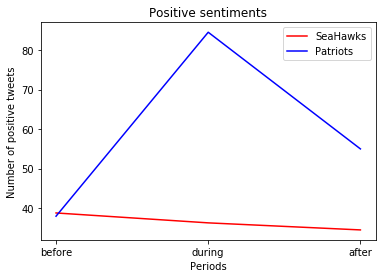

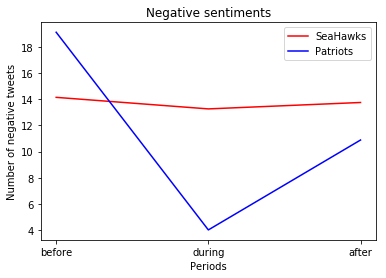

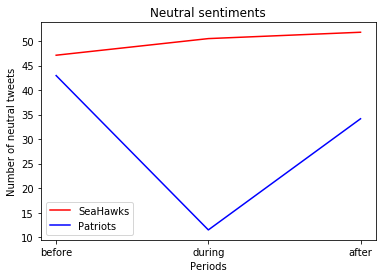

In [31]:
gohawk_pos = [38.76058506543495, 36.25377643504532, 34.468999386126455]
patriot_pos = [37.94259375654725, 84.49799196787149, 54.97296411600852]

gohawk_neu = [47.102471986998545, 50.49093655589124, 51.78637200736648]
patriot_neu = [42.949926670856904, 11.485943775100402, 34.147140750450596]

gohawk_neg = [14.136942947566505, 13.255287009063444, 13.74462860650706]
patriot_neg = [19.107479572595853, 4.016064257028113, 10.879895133540881]
  
        
plt.title("Positive sentiments")
plt.xlabel('Periods')
plt.ylabel('Number of positive tweets')
plt.plot(gohawk_pos, 'r', label='SeaHawks')
plt.plot(patriot_pos, 'b', label='Patriots')
plt.legend()
plt.xticks(np.arange(3), ['before', 'during', 'after'])
plt.show()

plt.title("Negative sentiments")
plt.xlabel('Periods')
plt.ylabel('Number of negative tweets')
plt.plot(gohawk_neg, 'r', label='SeaHawks')
plt.plot(patriot_neg, 'b', label='Patriots')
plt.legend()
plt.xticks(np.arange(3), ['before', 'during', 'after'])
plt.show()

plt.title("Neutral sentiments")
plt.xlabel('Periods')
plt.ylabel('Number of neutral tweets')
plt.plot(gohawk_neu, 'r', label='SeaHawks')
plt.plot(patriot_neu, 'b', label='Patriots')
plt.legend()
plt.xticks(np.arange(3), ['before', 'during', 'after'])
plt.show()